# Thermalization-inspired training of Restricted Boltzmann machines
## Notebook 4

Implementing here a quantum-mechanics-inspired RBM:

- Two components: System and Bath. Each has two visible units and one hidden unit

- Each node ($v_{S_0}, v_{S_1}, h_S, v_{B_0}, v_{B_1}, h_B$) can be pictured as a two-level system (classically, using random bit variable), or quantum mechanically using a qubit. 

- The energy gap of each node is equal to the corresponding bias of that node, and the coupling between all nodes is given to the weight matrix

Bath: 
- The bath state is described by an exponential form $\rho_B = \exp(-(\omega_{V_0} v_{B_0} + \omega_{V_1} v_{B_1} + \omega_H h_B + J_{00} v_{B_0} h_B + J_{10} v_{B_1} h_B) -\log Z_B))$, which is diagonal

- The bath biases/weights (equivalently, the Hamiltonian) is arranged such that only two configurations appear with non-vanishing probability (say, $00:0$ and $11:1$, so that the hidden unit controls the states of the visible units). 

- The bath state is frequently updated by drawing from the above distribution

System:
- The system begins in an arbitrary state (say 00)

- The system Hamiltonian is *not* diagonal! This is in order to ensure that there is some non-trivial self-evolution going on, so that information can propagate between visible and hidden units

- To evaluate the random variables associated with the visible units, we look at the diagonal states of the visible units (it may or may not be useful to actually collapse the system's visible units via measurement; for now, I let the environment do this)

Interaction:
- The system and bath have a simple SWAP interaction between visible units. For simplicity, just treat this as classical mixing with some mixing paramater $m$

Goal:
- at equilibrium, the *system* should also be in the state $\rho_S = \exp(-(\omega_{V_0} v_{S_0} + \omega_{V_1} v_{S_1} + \omega_H h_S + J v_S h_S) -\log Z_S))$

- Thus, the system hidden unit must be involved in order to correlate the visible units

In [1]:
import numpy as np
import scipy as sp
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline
from nn_systems import *

In [2]:
#repeatedly used operators

zero = qt.fock(2,0)
one = qt.fock(2,1)
meas_ops = []
meas_outcomes = []
for a in range(2):
    a_op = zero if a == 0 else one
    for b in range(2):
        b_op = zero if b == 0 else one
        for c in range(2):
            c_op = zero if c == 0 else one
            meas_ops.append(qt.tensor(a_op,b_op,c_op))
            meas_outcomes.append([a,b,c])

meas_outcomes = np.array(meas_outcomes)
    
#helper functions
                
def prob_to_binary(probs):
    return np.random.binomial(1,probs)

def update_bath(bath, beta = 0):
    x = 10.0
    H_B = np.diag([0,x,x,x,x,x,2*x,0]) #this gives 000 and 111 as most probable states, others much less probable
    rho = sp.linalg.expm(-beta*H_B)
    rho = rho/np.trace(rho)
    rho = qt.Qobj(rho)
    rho.dims = [[2,2,2],[2,2,2]]

    #pick diagonal measurement outcomes to probabilities from rho
    bath_state = meas_outcomes[np.random.choice(range(8),p=rho.diag())]
    new_vis0_state = [bath_state[0],1-bath_state[0]]
    new_vis1_state = [bath_state[1],1-bath_state[1]]
    new_hid_state = [bath_state[2],1-bath_state[2]]
    bath.layers['Visible'].update_nodes([new_vis0_state,new_vis1_state])
    bath.layers['Hidden'].update_nodes([new_hid_state])
    
    return bath

def interact_visible(sys1, sys2, density_matrix = None, mixing_prob = 0.1):
    m = mixing_prob
    
    if density_matrix is not None:
        rho = density_matrix
    else:
        rho = sys_to_product_dm(sys1) #make density matrix from classical populations    
    
    sys1_state = np.array(sys1.layers['Visible'].node_states())
    sys2_state = np.array(sys2.layers['Visible'].node_states())   
    
    rho = (1-m)*rho + m*sys_to_product_dm(sys2)

    #note: assumes evolution_method == 'measure_diag':
    #convert bloch vectors to their diagonal components, then measure in 0/1 basis
    rho_V = rho.ptrace(0)
    vis_prob = rho_V[0,0]
    vis_binary = prob_to_binary(vis_prob)
    new_visible_state = [vis_binary,1-vis_binary]
    
    sys1.layers['Visible'].update_nodes([new_visible_state])

    #sys1.layers['Visible'].update_nodes((1-m)*sys1_state + m*sys2_state) #no longer used    
    sys2.layers['Visible'].update_nodes((1-m)*sys2_state + m*sys1_state)
    
    return sys1, sys2, rho

def get_states(sys):
    visible0 = np.array(sys.layers['Visible'].node_states()[0]).flatten()
    visible1 = np.array(sys.layers['Visible'].node_states()[1]).flatten()
    hidden = np.array(sys.layers['Hidden'].node_states()).flatten()
    return visible0, visible1, hidden

def sys_to_product_dm(sys):
    visible0, visible1, hidden = get_states(sys)
    rho_V0 = qt.Qobj(np.diag(visible0))
    rho_V1 = qt.Qobj(np.diag(visible1))
    rho_H = qt.Qobj(np.diag(hidden))
    rho = qt.tensor(rho_V0, rho_V1, rho_H)  
    return rho

def evolve_sys(sys, generator, time, evolution_method ='measure_diag', density_matrix = None):
    if density_matrix is not None:
        rho = density_matrix
    else:
        rho = sys_to_product_dm(sys) #make density matrix from classical populations

    #for the moment, assume generator is a 2-qubit Hamiltonian
    
    #Note: the below code was numerically unstable 
    #the expm operation "leaks out" probability over time
    #I have included the renormalization hack to prevent this
    H = qt.Qobj(generator)
    H.dims = [[2,2,2],[2,2,2]]
    U = (1j*time*H).expm()
    rho = U*rho*U.conj()
    rho = rho/rho.tr()
    
    rho_V0 = rho.ptrace(0)
    rho_V1 = rho.ptrace(1)
    rho_H = rho.ptrace(2)

    if evolution_method == 'measure_diag':
        #convert bloch vectors to their diagonal components, then measure in 0/1 basis
        vis0_prob = rho_V0[0,0]
        vis0_binary = prob_to_binary(vis0_prob)
        new_visible0_state = [vis0_binary,1-vis0_binary]
        vis1_prob = rho_V1[0,0]
        vis1_binary = prob_to_binary(vis1_prob)
        new_visible1_state = [vis1_binary,1-vis1_binary]        
        hid_prob = rho_H[0,0]
        hid_binary = prob_to_binary(hid_prob)
        new_hidden_state = [hid_binary,1-hid_binary]
    else:
        print 'Invalid evolution_method. Keeping states fixed.'
        new_visible_state = visible
        new_hidden_state = hidden
    
    sys.layers['Visible'].update_nodes([new_visible0_state,new_visible1_state])
    sys.layers['Hidden'].update_nodes([new_hidden_state])
    
    return rho

def initialize():
    #set up system with random energies and couplings
    NUM_V_SYS = 2
    NUM_H_SYS = 1
    sys = System('RBM')
    sys.add_layer(NUM_V_SYS, name = 'Visible', energies = np.random.normal(size=NUM_V_SYS))
    sys.add_layer(NUM_H_SYS, name = 'Hidden', energies = np.random.normal(size=NUM_H_SYS))
    sys.couple_layers('Visible','Hidden',np.random.normal(size=(NUM_V_SYS,NUM_H_SYS)))
    
    #bath has fixed energies/couplings
    NUM_V_BATH = 2
    NUM_H_BATH = 1
    x = 10.0
    omega_V_bath = x #values chosen to get right distribution
    omega_H_bath = x
    J00 = -2.0*x
    J10 = -2.0*x
    J = np.array([J00,J10])
    beta_bath = 1.0
    bath = System('Bath')
    bath.add_layer(NUM_V_BATH, name = 'Visible', energies = [omega_V_bath, omega_V_bath])
    bath.add_layer(NUM_H_BATH, name = 'Hidden', energies = [omega_H_bath])
    bath.couple_layers('Visible','Hidden', J)
    
    return sys, bath

In [3]:
def run_evolution(sys, bath, rho, H, beta, mixing_prob, time_step, num_steps):
    store_rho = [rho]
    for ctr in range(num_steps):
        if mixing_prob > 0.0:
            bath = update_bath(bath,beta)
            sys, bath, rho = interact_visible(sys, bath, rho, mixing_prob)

        rho = evolve_sys(sys, H, time_step, density_matrix = rho)
        store_rho.append(rho)

        sys_visible0, sys_visible1, sys_hidden = get_states(sys)
        T = 1
        if ctr == 0:
            store_visible0 = sys_visible0
            store_visible1 = sys_visible1
            store_hidden = sys_hidden
        elif ctr % 1 == 0: #only save every T steps
            store_visible0 = np.vstack((store_visible0, sys_visible0))
            store_visible1 = np.vstack((store_visible1, sys_visible1))
            store_hidden = np.vstack((store_hidden, sys_hidden)) 
            
    return store_visible0, store_visible1, store_hidden, store_rho

def plot_diag(store_visible0,store_visible1,store_hidden):
    vis0_mean = np.array([list(np.mean(store_visible0[0:x],axis=0)) for x in range(1,num_steps)])  
    vis1_mean = np.array([list(np.mean(store_visible1[0:x],axis=0)) for x in range(1,num_steps)]) 
    hid_mean = np.array([list(np.mean(store_hidden[0:x],axis=0)) for x in range(1,num_steps)])

    ax1 = plt.subplot(1,3,1);
    plt.plot(store_visible0);
    plt.plot(vis0_mean ,'.');
    plt.subplot(1,3,2);
    plt.plot(store_visible1);
    plt.plot(vis1_mean ,'.');
    plt.subplot(1,3,3,sharey = ax1);
    plt.plot(store_hidden);
    plt.plot(hid_mean ,'.');
    ax1.set_ylim([0.0,1.0]);

def plot_bloch(store_rho):
    
    store_rho_V0 = [rho.ptrace(0) for rho in store_rho]
    store_rho_V1 = [rho.ptrace(1) for rho in store_rho]
    store_rho_H = [rho.ptrace(2) for rho in store_rho]
    
    b0 = qt.Bloch()
    b0.add_states(store_rho_V0)
    b0.show()
    b1 = qt.Bloch()
    b1.add_states(store_rho_V1)
    b1.show()
    c = qt.Bloch()
    c.add_states(store_rho_H)
    c.show()

# Run simulations

#### System disconnected from bath (self-evolution)

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


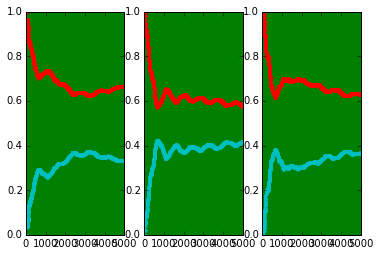

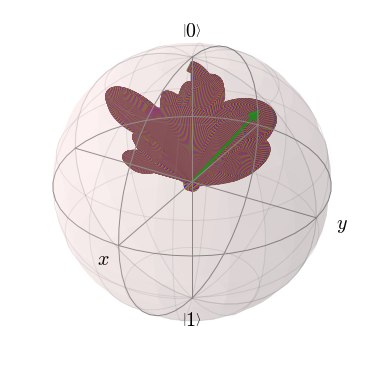

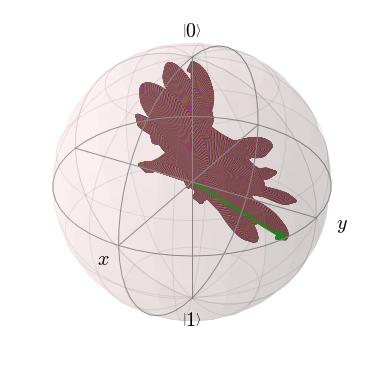

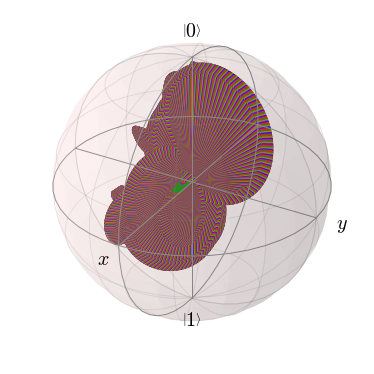

In [4]:
#iterate over many evolution steps
num_steps = 5000
mixing_prob = 0.00 #no bath interaction
time_step = 0.005
d = 2**(2+1)
np.random.seed(0)
H = np.random.uniform(size=(d,d))
H = (H+H.T)/2
sys, bath = initialize()
rho = sys_to_product_dm(sys)
beta = 100.0

store_visible0_nobath, store_visible1_nobath, store_hidden_nobath, store_rho_nobath = run_evolution(sys, bath, rho, H, beta, mixing_prob, time_step, num_steps) 

plot_diag(store_visible0_nobath,store_visible1_nobath,store_hidden_nobath)
plot_bloch(store_rho_nobath)

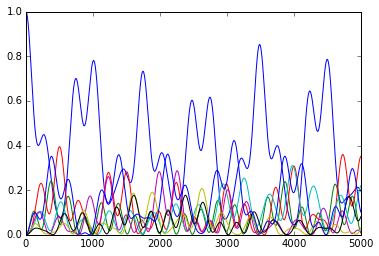

In [5]:
test_nobath = [rho.diag() for rho in store_rho_nobath]
plt.plot(test_nobath);

In [6]:
test2_nobath = np.array([rho.full() for rho in store_rho_nobath])
rho_diag_avg_nobath = qt.Qobj(np.mean(test2_nobath,axis=0)).diag()
print rho_diag_avg_nobath

[ 0.38015042  0.07875991  0.11751002  0.0953294   0.07164907  0.04828684
  0.05470273  0.15361159]


#### System connected to high-temperature correlated bath

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


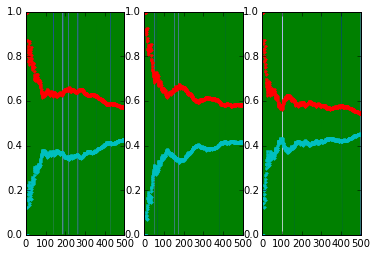

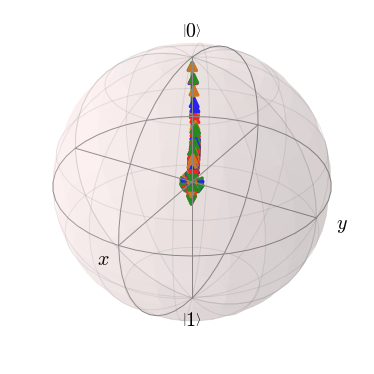

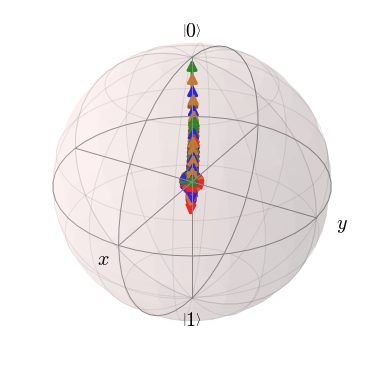

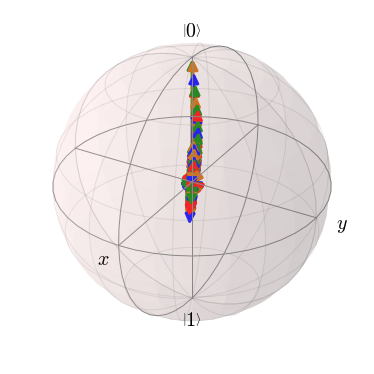

In [7]:
#iterate over many evolution steps
num_steps = 500
mixing_prob = 0.05
time_step = 0.005
d = 2**(2+1)
np.random.seed(0)
H = np.random.uniform(size=(d,d))
H = (H+H.T)/2
sys, bath = initialize()
rho = sys_to_product_dm(sys)
beta = 0.0

store_visible0_highT, store_visible1_highT, store_hidden_highT, store_rho_highT = run_evolution(sys, bath, rho, H, beta, mixing_prob, time_step, num_steps) 

plot_diag(store_visible0_highT,store_visible1_highT,store_hidden_highT)
plot_bloch(store_rho_highT)

#### System connected to low-temperature  correlated bath

/home/coolguy/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/matfuncs.py:695: RuntimeWarning: overflow encountered in sinh
  return np.sinh(x) / x
/home/coolguy/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/matfuncs.py:719: RuntimeWarning: invalid value encountered in double_scalars
  return t_12 * np.exp(a) * _sinch(b)
/home/coolguy/anaconda/lib/python2.7/site-packages/qutip/qobj.py:1511: RuntimeWarning: invalid value encountered in greater
  self._isherm = False if np.any(h > settings.atol) else True
/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


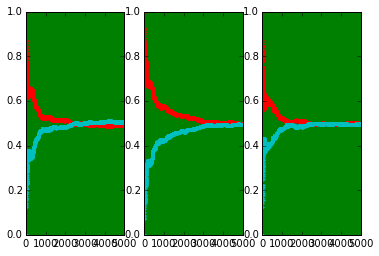

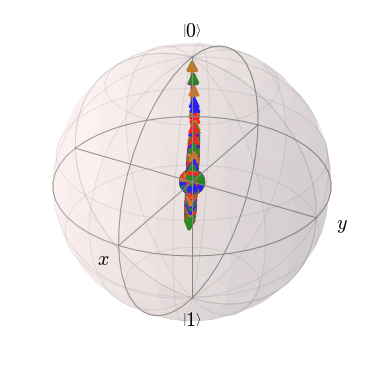

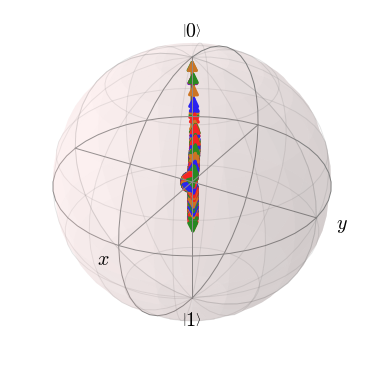

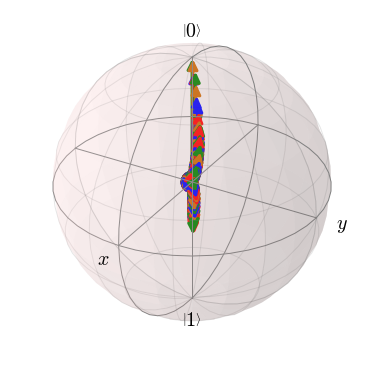

In [8]:
#iterate over many evolution steps
num_steps = 5000
mixing_prob = 0.05
time_step = 0.005
d = 2**(2+1)
np.random.seed(0)
H = np.random.uniform(size=(d,d))
H = (H+H.T)/2
sys, bath = initialize()
rho = sys_to_product_dm(sys)
beta = 100.0

store_visible0_lowT, store_visible1_lowT, store_hidden_lowT, store_rho_lowT = run_evolution(sys, bath, rho, H, beta, mixing_prob, time_step, num_steps) 

plot_diag(store_visible0_lowT,store_visible1_lowT,store_hidden_lowT)
plot_bloch(store_rho_lowT)

# Workspace

In [9]:
#compare with thermal state of this Hamiltonian at inverse temp beta
t = sp.linalg.expm(-beta*H)
t = t/np.trace(t)
qt.Qobj(t)

Quantum object: dims = [[8], [8]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.22010161 -0.2227854   0.172351    0.04275473  0.12234013 -0.07931211
  -0.12936474 -0.22912435]
 [-0.2227854   0.22550192 -0.17445255 -0.04327606 -0.12383188  0.08027919
   0.13094214  0.23191816]
 [ 0.172351   -0.17445255  0.13495979  0.03347918  0.09579868 -0.0621055
  -0.10129931 -0.17941627]
 [ 0.04275473 -0.04327606  0.03347918  0.0083051   0.02376457 -0.01540637
  -0.0251291  -0.0445074 ]
 [ 0.12234013 -0.12383188  0.09579868  0.02376457  0.0680009  -0.04408443
  -0.07190542 -0.12735529]
 [-0.07931211  0.08027919 -0.0621055  -0.01540637 -0.04408443  0.02857958
   0.0466157   0.08256339]
 [-0.12936474  0.13094214 -0.10129931 -0.0251291  -0.07190542  0.0466157
   0.07603413  0.13466785]
 [-0.22912435  0.23191816 -0.17941627 -0.0445074  -0.12735529  0.08256339
   0.13466785  0.23851696]]

In [10]:
store_rho_lowT[-1]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = [8, 8], type = oper, isherm = True
Qobj data =
[[ 0.44863614 +0.00000000e+00j -0.00397271 -3.93091010e-02j
  -0.00570472 -1.30418229e-02j -0.00413677 -1.44227346e-02j
  -0.00553775 -1.96476535e-02j -0.00536607 -2.31391903e-02j
  -0.00249728 -1.68507139e-02j -0.00756167 -1.54926171e-03j]
 [-0.00397271 +3.93091010e-02j  0.00635493 +0.00000000e+00j
   0.00298533 -7.65598010e-04j  0.00301080 -4.37499632e-04j
   0.00375858 -7.04936447e-04j  0.00389335 -7.43741350e-04j
   0.00316833 -3.34578281e-05j -0.00218504 +6.05087415e-03j]
 [-0.00570472 +1.30418229e-02j  0.00298533 +7.65598010e-04j
   0.00436950 +0.00000000e+00j  0.00371821 +7.62382327e-05j
   0.00358383 +1.38366613e-05j  0.00210295 +3.29315095e-07j
   0.00314598 +3.43296108e-04j -0.00429822 +2.82031928e-02j]
 [-0.00413677 +1.44227346e-02j  0.00301080 +4.37499632e-04j
   0.00371821 -7.62382327e-05j  0.00322402 +0.00000000e+00j
   0.00318833 -1.12185315e-04j  0.00203775 -1.74519306e

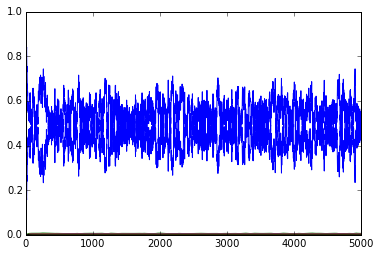

In [11]:
test_lowT = [rho.diag() for rho in store_rho_lowT]
plt.plot(test_lowT);

In [12]:
test2_lowT = np.array([rho.full() for rho in store_rho_lowT])
rho_diag_avg_lowT = qt.Qobj(np.mean(test2_lowT,axis=0)).diag()
print rho_diag_avg_lowT

[ 0.48750324  0.00617419  0.00435859  0.00322199  0.00331107  0.00245816
  0.00253346  0.4904393 ]


### Summary
- Near steady state, clearly the RBM system is not in a $\beta$-thermal state of the system Hamiltonian

- rather, it is approximately in the state $\rho_S\sim\frac{1}{2}[000+111]\sim\rho_B$! (which is what we wanted!)
